## Causal Inference Techniques

**Note: This notebook it's only to store causal inference studies.**

### Dataset Description
Here i'll be using the Lalonde dataset. This dataset was used to evaluate propensity score matching.<br>Two demos are provided which use this dataset. The first, DehejiaWahba, replicates one of the models from Dehejia and Wahba (1999). The second demo, AbadieImbens, replicates the models produced by Abadie and Imbens http://scholar.harvard.edu/imbens/scholar_software/matching-estimators. Many of these models are found to produce good balance for the Lalonde data.

In [1]:
# Imports
import warnings
warnings.filterwarnings("ignore")

import pandas as pd # data manipulation
import numpy as np # linear algebra

import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
from causalinference import CausalModel # causal inference lib
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller test
import statsmodels.api as sm # statsmodels
from linearmodels.iv import IV2SLS # 2SLS
from statsmodels.tsa.stattools import grangercausalitytests # Granger Causality Test
from sklearn.linear_model import LogisticRegression # Logistic Regression for Propensity Score
from sklearn.ensemble import RandomForestClassifier # Model m at Doubly Robust Estimator

sns.set_style("whitegrid")
%matplotlib inline

In [2]:
df = pd.read_stata('lalonde.dta').drop(columns = 'data_id')
df.head()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898
1,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219
3,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996
4,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886


### Exploratory Data Analysis

For now let's check the proportions of treatment and no treatment.

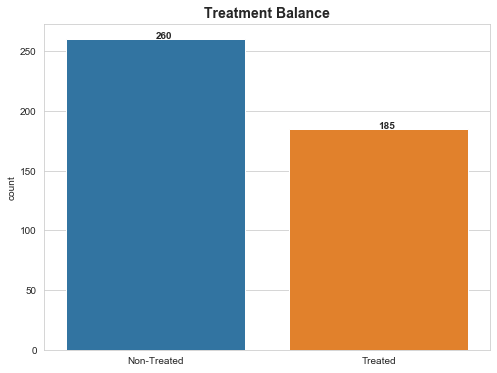

In [3]:
# Data manipulation to a more cool plot
treat_balance = (df['treat']
                 .value_counts()
                 .reset_index()
                 .rename(columns = {'treat':'count'}))
treat_balance.index = ['Non-Treated', 'Treated']
treat_balance = treat_balance.drop(columns = 'index').reset_index()

# Barplot
plt.figure(figsize = (8,6))
plt.title('Treatment Balance', weight='bold', fontsize = 14)
ax = sns.barplot(x = 'index', y = 'count', data = treat_balance.reset_index())
xlocs, xlabs = plt.xticks()
for i, v in enumerate(treat_balance['count']):
    plt.text(xlocs[i], v + 0.5, str(v), weight='bold')
plt.xlabel('')
plt.show()

Seems that our control group has higher earning that the treatment group, let's check the distribution of each one.

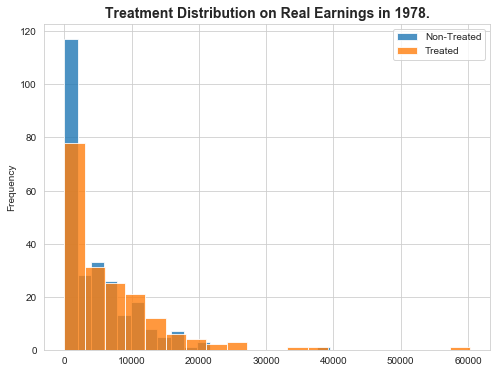

In [4]:
# Data manipulation to a more cool plot
treat_dist = (df.groupby('treat')['re78'])

# Histogram
plt.figure(figsize = (8,6))
plt.title('Treatment Distribution on Real Earnings in 1978.', weight='bold', fontsize = 14)
treat_dist.plot.hist(bins = 20, alpha = .8)
plt.legend(['Non-Treated', 'Treated'])
plt.show()

The graph above confirm to us that the control group has a higher real earnings, what about the distribution of our covariates $X$.

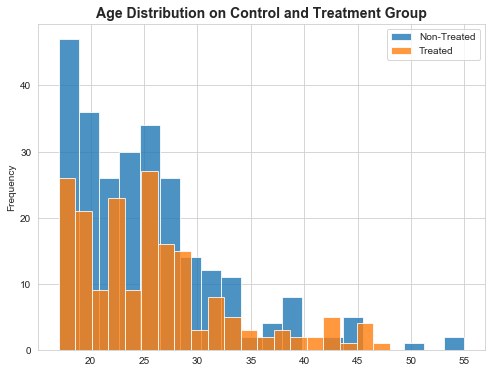

In [5]:
# Data manipulation to a more cool plot
age_dist = (df.groupby('treat')['age'])

# Histogram
plt.figure(figsize = (8,6))
plt.title('Age Distribution on Control and Treatment Group', weight='bold', fontsize = 14)
age_dist.plot.hist(bins = 20, alpha = .8)
plt.legend(['Non-Treated', 'Treated'])
plt.show()

The age of the participants of the current study was around 18 ~ 35 years old so probably if we use a technique called [Matching](https://en.wikipedia.org/wiki/Matching_(statistics)) which was developed as part of the [Rubin causal model](https://en.wikipedia.org/wiki/Rubin_causal_model) we would get good estimates. Soon we will talk more about it.

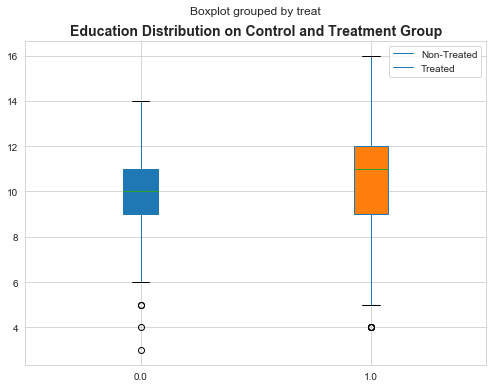

In [6]:
# Box-plot
boxes = df.boxplot(column = ['education'], by = 'treat', figsize = (8,6), patch_artist = True, return_type = 'both')
colors = ['C0', 'C1']
for row_key, (ax,row) in boxes.iteritems():
    ax.set_xlabel('')
    for i,box in enumerate(row['boxes']):
        box.set_facecolor(colors[i])
plt.title('Education Distribution on Control and Treatment Group', weight='bold', fontsize = 14)
plt.legend(['Non-Treated', 'Treated'])
plt.show()

The education distribution fall around 9 to 11 years studying at our control group with mean of 10 years plus some outliers.<br>
At the treatment group it falls around 9 to 12 years studying with a mean of 11 years.<br>

### Getting comfortable with Concepts

Basically on observational studies we will have $covariate$ also know as $confounding variables$ which is our features (in that case is age, education, married, etc), the $response$ that is what we are studing, like if the politicians put more taxes on products does it affect on sales of Wallmart? So our response would be the sales of Wallmart, the $treatment$ at time-series a dummy variable on the period before and after the increase of the taxes.<br>
<b> Summary </b>
- $X$ represents the covariates; confounding variables;
- $Y$ represents the response;
- $T$ represents the treatment;
<br>
<br>
<br>
<b>A brief summary of the techniques that we will approach here:</b>
- Difference-in-Differences
- Granger Causality
- Propensity Score Matching
- Inverse Probability of Treatment Weighting (IPTW)
- Doubly Robust Estimation
- Instrumental Variables

#### Average Treatment Effect
Before we get into a more complex models, we need to know how to estimate the average treatment effect (**$ATE$**). The traditional way to estimate it is basically:
$$\Delta = E[Y_1 - Y_0]$$
$$\Delta_{row} = E[Y \mid T = 1] - E[Y \mid T = 0] = E[Y_1 \mid T = 1] - E[Y_0 \mid T = 0] \ne E[Y_1 - Y_0]$$
A really common concept that may be strange for a lot of people at first sight is that formula below:
$$E[Y_i \mid T = i] \ne E[Y_i]$$
First let's me describe each term so it may be more easy to understand. $E[Y_i \mid T = i]$ is the expected outcome given the treatment which uses a Bayes Theorem and $E[Y_i]$ is the expected value at $i$. See the difference? The first term has a conditional probability and the other one doesn't.<br>
#### Causal Inference Assumptions
Most common assumptions:
- SUTVA (Stable Unit Treatment Value Assumption)
- Consistency
- Ignorability
- Positivity

<b>SUTVA</b>: Means that no other treatment intefere in another treatment.<br>
<b>Consistency</b>: An individual's potential outcome under his or her observed exposure history is the outcome that will actually be observed for that person.<br>
<b>Ignorability</b>: If we want to interpret the regression coefficient for treatment as an average causal effect then all the counfounding covariates should be controlled for in the regression model.<br>
<b>Positivity</b>: There's no possible way to get a negative probability of an event.<br>

### Difference-in-Differences
Difference-in-Differences (DiD or DD) is actually a quasi-experimental method which compare the difference between the outcome population which was into the treatment and the population which wasn't. The mathematical notation would be something like this:<br>
$$ControlDifference = E[\overline{Y_1^C}] - E[\overline{Y_0^C}]$$
$$TreatmentDifference = E[\overline{Y_1^T}] - E[\overline{Y_0^T}]$$
$$DD = TreatmentDifference - ControlDifference$$

In [7]:
covariates = ['age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're74', 're75']

causal = CausalModel(
    Y=df['re78'].values, 
    D=df['treat'].values, 
    X=df[covariates].values)

causal.est_via_ols(adj=1)

print(causal.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   1676.343    669.087      2.505      0.012    364.933   2987.753



Seems like our Ordinary Least Squares regression give us some interesting results. Let's make a summary here.<br>
- A estimative around 1676 dollars per year<br>
- A 95% of confidence that our earnings in 1978 would be around 364 and 2987 dollars<br>
- The p-value of 0.012 reject the null hipothesis of no treatment effect<br>


### Granger Causality
Granger Causality verifies if the lag of the current covariates influences into forecasting the next value of $Y$. Also we have some ways to find out which is the a good number of lags of the features. A really common way is to run a Granger Causality test to verify if the lag that we are applying will help.<br>
To run the test we need to see if our time-series is stationary that we could use the Augmented Dickey-Fuller test. Which mathematically come like this:<br>
$$\Delta{y_t} = \alpha + \beta{t} + \gamma{y_{t-1}} + \delta_1{\Delta{y_{t-1}}} + \delta_1{\Delta{y_{t-2}}} + ...$$
And the we run our Granger Causality test for optimal lags.<br>
<br>
Let's begin with the Augmented Dickey-Fuller test.<br>
<br>
$H_0$ = Time-Series Non-Stationary<br>
$H_1$ = Time-Series Stationary

In [8]:
# Augmented Dickey-Fuller
result = adfuller(df['re78'].values, autolag='AIC')
print(f'Augmented Dickey-Fuller Statistic: {result[0]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t%{key}: {value}')

Augmented Dickey-Fuller Statistic: -21.338109313770715
Critical Values:
	%1%: -3.4451642100030084
	%5%: -2.8680716196949327
	%10%: -2.5702491139112085


Since our value of the current test is below all the critical values, we can reject the null hypothesis that our series is non-stationary.

In [9]:
grangercausalitytests(df[['re78', 'education']], maxlag = 5).__repr__


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2718  , p=0.6024  , df_denom=441, df_num=1
ssr based chi2 test:   chi2=0.2736  , p=0.6009  , df=1
likelihood ratio test: chi2=0.2735  , p=0.6010  , df=1
parameter F test:         F=0.2718  , p=0.6024  , df_denom=441, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.6741  , p=0.0037  , df_denom=438, df_num=2
ssr based chi2 test:   chi2=11.4777 , p=0.0032  , df=2
likelihood ratio test: chi2=11.3316 , p=0.0035  , df=2
parameter F test:         F=5.6741  , p=0.0037  , df_denom=438, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8775  , p=0.0093  , df_denom=435, df_num=3
ssr based chi2 test:   chi2=11.8198 , p=0.0080  , df=3
likelihood ratio test: chi2=11.6645 , p=0.0086  , df=3
parameter F test:         F=3.8775  , p=0.0093  , df_denom=435, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.9515  , p=0.0199  

<method-wrapper '__repr__' of dict object at 0x1a1da4caa0>

Look's like a lag of 3 would be a great choice for us to use lag of 5 for education, which means that this could be helpful to predict the next value.

### Propensity Score Matching


Before start with propenstity score matching let's understand first what is the [Propensity Score](https://www.researchgate.net/publication/243082748_The_Central_Role_of_the_Propensity_Score_in_Observational_Studies_For_Causal_Effects#:~:text=The%20ability%20of%20the%20propensity,the%20treatment%20and%20control%20groups).<br>
Propensity Score is the probability of treatment assignment conditional on observed data. We can think about that if we have two pacients which one received and the other one didn't received a treatment for any disease, if we think that they have the same probability of receiving the treatment, the reason behind receiving or not receiving a treatment is a chance, we can see below that since i condition on $P(x)$ i'll have everything i need to estimate what T would be.
$$E[T|P(x), X] = E[T|P(x)]$$
where
$$P(x) = P(T=t|X=x)$$
which can be also be represented by $\pi(x)$.

Now that we know what propensity score is, we need to estimate this into a real world problem, a common way to do so it's using a Logistic Regression also know as Logit but other algorithmns can be taken to estimate the propensity score.

In [10]:
logit = LogisticRegression().fit(df[covariates], df['treat'])
df_ps = df.assign(propensity_score = logit.predict_proba(df[covariates])[:, 1])

In [11]:
df_ps.head()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78,propensity_score
0,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898,0.428836
1,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043,0.315764
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219,0.553978
3,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996,0.376080
4,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886,0.392726


Now that we calculated the Propensity Score, we can match the the data, also we can have more than a single match but let's keep it simple for now, i'll use a bias adjustment to make a more precise matching. We have a enormous varieties of mensure the distance between two vectors from the same dataset.<br>
Some examples:<br>
- Euclidian Distance
- Mahalanobis Distance
<br>

The Euclidian Distance is given by:<br>
$$d_m(x,y) = \sqrt{(x - y)^T(x - y)}$$
and the Mahalanobis Distance is given by:<br>
$$d_m(x,y) = \sqrt{(x - y)^TS^{-1}(x - y)}$$
$S^{-1}$ = Inverse Covariance Matrix of the independent variables<br>
Note that the Mahalanobis Distance equals to the Euclidian Distance considering how much correlated the variables are. Those two formulas are highly used in Machine Learning algorithmns like K-Nearest Neighbors to get the closest points.

In [12]:
causal = CausalModel(
    Y = df_ps["re78"].values, 
    D = df_ps["treat"].values, 
    X = df_ps[["propensity_score"]].values
)

causal.est_via_matching(matches = 1, bias_adj = True)

print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   1595.714   1020.676      1.563      0.118   -404.811   3596.239
           ATC   1528.307   1152.283      1.326      0.185   -730.167   3786.781
           ATT   1690.449   1178.555      1.434      0.151   -619.520   4000.417



### Inverse Probability of Treatment Weighting
We know how to estimate the propensity score so the weight of every person from the treatment group can be estimated by:
$$w(x) = \frac{1}{\pi(x)}$$
and for everyone from the control group should be approximately:
$$w(x) = \frac{1}{1-\pi(x)}$$
But looking for these two types of weight for each case we can build a formula that represents our $IPTW$.
$$IPTW = \frac{1}{n_T}\sum_{i:T_i=1}\frac{Y_i}{\pi(X_i)} - \frac{1}{n_C}\sum_{i:T_i=0}\frac{Y_i}{1 - \pi(X_i)}$$
This still look's that can be generalized.
$$IPTW = \frac{1}{n}\sum_{i}^n\frac{T_iY_i}{\pi(X_i)} - \frac{1}{n}\sum_{i}^n\frac{(1 - T_i)Y_i}{1 - \pi(X_i)}$$
for a more easy understandable we can substitute the mean symbol for a $E$. Which becomes a:
$$IPTW = E\Big[\frac{TY}{\pi(X)}\Big] - E\Big[\frac{(1 - T)Y}{1 - \pi(X)}\Big]$$
But after all, what are the benefits of the IPTW? That technique can create us a unconfounded pseudo-population based on the propensity score, we can create a simple example for analysing the weights. e.g. Given the X covariates our estimator for propensity score tell us that this person should not be treated but in practice we know that this person should be considerer for a treatment group, what will happen with the weight of it? It will have a small or large weight? For this case it will have a large weight but this make us a complication making our model unstable.<br>
Given this issue of large weights getting our model a lower perfomance we can use a model with stabilized weights.<br>
That just remove from the treatment group the weight:<br>
$$w(x) = \frac{1}{\pi(x)}$$
for
$$w(x) = \frac{P(T=1)}{\pi(x)}$$
And for the control group we get:
$$w(x) = \frac{1 - P(T = 1)}{1 - \pi(x)}$$

In [13]:
df_ps['ips'] = np.where(df_ps['treat'] == 1,
                       1/df_ps['propensity_score'],
                       1/ (1 - df_ps['propensity_score']))
df_ps['ipsw'] = df_ps['ips'] * df_ps['re78']

In [14]:
df_ps.head()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78,propensity_score,ips,ipsw
0,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898,0.428836,2.331894,23155.809946
1,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043,0.315764,3.166920,11387.910482
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219,0.553978,1.805124,44964.657014
3,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996,0.376080,2.659009,19958.912637
4,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886,0.392726,2.546301,737.892382


Let's see our estimator.

In [15]:
(df_ps.query("treat == 1")['ipsw'].sum() - df_ps.query("treat == 0")['ipsw'].sum())/df_ps.shape[0]

1573.5218889051453

We could do the same thing with causalinference package.

In [16]:
df_psc = df_ps.copy()

causal = CausalModel(
    Y=df['re78'].values, 
    D=df['treat'].values, 
    X=df[covariates].values)

causal.est_propensity_s()

ps = causal.propensity["fitted"]
df_psc['ips'] = np.where(df_psc['treat'] == 1,
                       1/df_psc['propensity_score'],
                       1/ (1 - df_psc['propensity_score']))
df_psc['ipsw'] = df_psc['ips'] * df_psc['re78']

(df_psc.query("treat == 1")['ipsw'].sum() - df_psc.query("treat == 0")['ipsw'].sum())/df_psc.shape[0]

1573.5218889051453

### Doubly Robust Estimator
So, what makes a Doubly Robust Estimator? All estimator can be biased right? With that in mind several people tried to combine models to create a good estimator. What we can use while trying to create a Doubly Robust Estimator? Well, we already have our first step: the Inverse Probability Treatment Weighting (IPTW) and our second step is any other model $m$. Keep in mind that the most used model i seen around papers and articles is OLS. So basically the Doubly Robust combine both approuches to a unique estimator.<br>
Note: The $m$ model can be any model from RandomForests to OLS.<br>
<br>
Let's explain this is a more clear way to implement this after.<br>
Our model $m$ will give us:
$$m_t = E[Y|T = t, X]$$
where

$$t = \begin{cases}
    1       & \quad \text{if } \text{is treatment group}\\
    0  & \quad \text{if }\text{is control group}
  \end{cases}
$$

With that in mind we get the current equation representing our combination:<br>
$$ATE_{DR} = \frac{1}{n}\sum_{i=1}^n\Big[\frac{T_i Y_i}{\pi(X_i)} - \frac{T_i - \pi(X_i)}{\pi(X_i)}m_1(X_i)\Big] - \frac{1}{n}\sum_{i=1}^n\Big[\frac{(1 - T_i) Y_i}{1 - \pi(X_i)} + \frac{T_i - \pi(X_i)}{1 - \pi(X_i)}m_0(X_i)\Big]$$
Replacing some terms we get:<br>
$$ATE_{DR} = E\Big[\frac{T Y}{\pi(X)} - \frac{T - \pi(X)}{\pi(X)}m_1(X)\Big] - E\Big[\frac{(1 - T) Y}{1 - \pi(X)} + \frac{T - \pi(X)}{1 - \pi(X)}m_0(X)\Big]$$

In [17]:
rf = RandomForestClassifier(n_estimators = 500, n_jobs = -1, random_state = 42)
rf.fit(df[covariates].values, df['treat'].values)
m = rf.predict_proba(df[covariates])[:, 1]

e1 = np.mean(((df['treat'] * df['re78'])/df_psc['propensity_score']) - ((df['treat'] - df_psc['propensity_score'])/df_psc['propensity_score']) * m)
e0 = np.mean((((1 - df['treat']) * df['re78'])/(1 - df_psc['propensity_score'])) + ((df['treat'] - df_psc['propensity_score'])/(1 - df_psc['propensity_score'])) * m)

e1 - e0

1573.0354979711092

### Instrumental Variables
An instrumental variable is a variable used in regression analysis when you have some endogenous variables that are influenced by other features in the model, with that in mind we can trust this variable to guarantee some unexpected actions at the outcome.
Basically an instrumental variable 'z' is one that is correlated with 'x' but not with the error term.<br>
![Instrumental Variable as DAG (Direct Acyclic Graph)](./iv.png)
<br>
We have a lot of ways to estimate the effect with a instrumental variable, in this session i'll estimate by the 2SLS.

#### 2SLS (Two Stage Least Squares)
To show how Two Stage Least Squares work, let's bring it to a real world problem, the current dataset represents the economic outcomes are proxied by GDP per capita in 1995.<br>
The columns represents:<br>
- shortnam: Shortname for the country
- africa: If is part of Africa
- avexpr: Average Expropriation Risk 1985-1995
- logpgp95: Log GDP per Capita in 1995
- logem4: Log of Setter Mortality
...

**First stage**<br>
The first stage is basically calculate a linear regression on the endogenous variable represented by ${avexpr}$ on the instrument.<br>
Our instrument in this case would be a constant like 1 and setter mortality represented by ${logem4}$.<br>
So we will have something like this:

$$avexpr = \beta_0 + \beta_1 logem4$$

**Second stage**<br>
Now that we have our first model, we need to predict the outcome for our endogenous variable to have a estimated variable that we will use on this stage. After predicting we will have the $\hat{avexpr}$.<br>
Keeping that in mind, we now regress our estimated endogenous variable on the desired outcome which will be $logpgp95$.<br>
Which will give us the next equation:<br>
$$logpgp95 = \beta_0 + \beta_1\hat{avexpr}$$

In [18]:
# Import and select the data
df = pd.read_stata('https://github.com/QuantEcon/lecture-source-py/blob/master/source/_static/lecture_specific/ols/maketable4.dta?raw=true')
df = df[df['baseco'] == 1]

# Add a constant variable
df['const'] = 1

# Fit the first stage regression and print summary
first_stage = sm.OLS(df['avexpr'],
                    df[['const', 'logem4']],
                    missing='drop').fit()
print(first_stage.summary())

                            OLS Regression Results                            
Dep. Variable:                 avexpr   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     22.95
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           1.08e-05
Time:                        00:04:37   Log-Likelihood:                -104.83
No. Observations:                  64   AIC:                             213.7
Df Residuals:                      62   BIC:                             218.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3414      0.611     15.296      0.0

In [19]:
# Estimate the average expropriation risk
df['predicted_avexpr'] = first_stage.predict()

# Regress our estimated value on the outcome
second_stage = sm.OLS(df['logpgp95'],
                    df[['const', 'predicted_avexpr']]).fit()
print(second_stage.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     56.60
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           2.66e-10
Time:                        00:04:37   Log-Likelihood:                -72.268
No. Observations:                  64   AIC:                             148.5
Df Residuals:                      62   BIC:                             152.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.9097      0.823  

Cool, now we know how to calculate the Two Stage Least Squares manually with OLS, but it's now recommended, we can use the IV2SLS from linearmodels to do that, which do all of these step in a single function, we just need to pass the required parameters.

In [20]:
iv = IV2SLS(dependent = df['logpgp95'],
            exog = df['const'],
            endog = df['avexpr'],
            instruments = df['logem4']).fit(cov_type='unadjusted')
print(iv.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:               logpgp95   R-squared:                      0.1870
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1739
No. Observations:                  64   F-statistic:                    37.568
Date:                Thu, Oct 08 2020   P-value (F-stat)                0.0000
Time:                        00:04:39   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          1.9097     1.0106     1.8897     0.0588     -0.0710      3.8903
avexpr         0.9443     0.1541     6.1293     0.00

The results above show us that we have estimated that institutional differences can help to explain differences in income levels across countries today.

### Cool Resources to checkout
- Mostly Harmless Econometrics: An Empiricist's Companion (English Edition)
- Mastering 'Metrics: The Path from Cause to Effect
- QuantEcon
- A Crash Course in Causality: Inferring Causal Effects from Observational Data
- Design of Observational Studies